
# pPXF: Stellar population and gas emission lines

![pPXF](https://www-astro.physics.ox.ac.uk/~cappellari/software/ppxf_logo.svg)

## Description

Usage example for the procedure pPXF originally described in 
[Cappellari & Emsellem (2004)](http://adsabs.harvard.edu/abs/2004PASP..116..138C),
substantially upgraded in 
[Cappellari (2017)](http://adsabs.harvard.edu/abs/2017MNRAS.466..798C) 
and with the inclusion of photometry and linear constraints in 
[Cappellari (2023)](https://ui.adsabs.harvard.edu/abs/2023MNRAS.526.3273C).

This example shows how to study stellar population and include gas emission
lines as templates instead of masking them using the `goodpiixels` keyword.

### MODIFICATION HISTORY

- V1.0.0: Adapted from PPXF_KINEMATICS_EXAMPLE.
      Michele Cappellari, Oxford, 12 October 2011
- V1.1.0: Made a separate routine for the construction of the templates
      spectral library. MC, Vicenza, 11 October 2012
- V1.1.1: Includes regul_error definition. MC, Oxford, 15 November 2012
- V2.0.0: Translated from IDL into Python. MC, Oxford, 6 December 2013
- V2.0.1: Fit SDSS rather than SAURON spectrum. MC, Oxford, 11 December 2013
- V2.1.0: Includes gas emissions as templates instead of masking the spectrum.
      MC, Oxford, 7 January 2014
- V2.1.1: Support both Python 2.6/2.7 and Python 3.x. MC, Oxford, 25 May 2014
- V2.1.2: Illustrates how to print and plot emission lines.
      MC, Oxford, 5 August 2014
- V2.1.3: Only includes emission lines falling within the fitted wavelength
      range. MC, Oxford, 3 September 2014
- V2.1.4: Explicitly sort template files as glob() output may not be sorted.
      Thanks to Marina Trevisan for reporting problems under Linux.
      MC, Sydney, 4 February 2015
- V2.1.5: Included origin='upper' in imshow(). Thanks to Richard McDermid
      for reporting a different default value with older Matplotlib versions.
      MC, Oxford, 17 February 2015
- V2.1.6: Use color= instead of c= to avoid new Matplotlib bug.
      MC, Oxford, 25 February 2015
- V2.1.7: Uses Pyfits from Astropy to read FITS files.
      MC, Oxford, 22 October 2015
- V2.1.8: Included treatment of the SDSS/MILES vacuum/air wavelength difference.
      MC, Oxford, 12 August 2016
- V2.1.9: Automate and test computation of nAge and nMetals.
      MC, Oxford 1 November 2016
- V3.0.0: Major upgrade. Compute mass-weighted population parameters and M/L
      using the new `miles` class which leaves no room for user mistakes.
      MC, Oxford, 2 December 2016
- V3.0.1: Make files paths relative to this file, to run the example from
      any directory. MC, Oxford, 18 January 2017
- V3.1.0: Use ppxf method pp.plot(gas_component=...) to produce gas emission
      lines plot. MC, Oxford, 13 March 2017
- V3.2.0: Uses new ppxf keywords `gas_component` and `gas_names` to print the
      fluxes and formal errors for the gas emission lines.
      Uses different kinematic components for the Balmer lines and the rest.
      MC, Oxford, 28 June 2017
- V3.3.0: Illustrate how to tie the Balmer emission lines and fit for the
      gas reddening using the `tie_balmer` keyword. Also limit doublets.
      MC, Oxford, 31 October 2017
- V3.3.1: Changed imports for pPXF as a package.
      Make file paths relative to the pPXF package to be able to run the
      example unchanged from any directory. MC, Oxford, 17 April 2018
- V3.3.2: Dropped legacy Python 2.7 support. MC, Oxford, 10 May 2018
- V4.0.3: Fixed clock DeprecationWarning in Python 3.7.
      MC, Oxford, 27 September 2018
- V4.1.0: Produce light-weighted instead of mass-weighted quantities and show
      how to convert between the two. MC, Oxford, 16 July 2021
- V4.2.0: Use E-Miles spectral library. MC, Oxford, 16 March 2022
- V4.3.0: Use the new `sps_util` instead of `miles_util`. 
      MC, Oxford, 12 November 2023
- V4.4.0: Included XSL SPS models. MC, Oxford. 29 may 2024

___

In [1]:
from time import perf_counter as clock
from pathlib import Path
from urllib import request

import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

from ppxf.ppxf import ppxf
import ppxf.ppxf_util as util
import ppxf.sps_util as lib

The two variables below define whether one wants to fit the Balmer lines as
individual lines with free fluxes, or as a single component, with relative
fluxes dictated by atomic physics. Similarly, the [SII] doublet can be fit
individually, or they can have their flux ratios limited (biu not fixed) by
atomic physics (see details in the docstring of `ppxf.util.emission_lines`).

In [2]:
tie_balmer = True
limit_doublets = True

Read SDSS DR8 galaxy spectrum taken from the [SDSS archive](http://www.sdss3.org/dr8/).
The spectrum is *already* log rebinned by the SDSS DR8 pipeline and
`log_rebin` should not be used in this case.

In [3]:
ppxf_dir = Path(lib.__file__).parent
file = ppxf_dir / 'spectra' / 'NGC3522_SDSS_DR8.fits'
hdu = fits.open(file)
t = hdu[1].data
redshift = float(hdu[1].header["Z"]) # SDSS redshift estimate

galaxy = t['flux']/np.median(t['flux'])   # Normalize spectrum to avoid numerical issues
wave = t['wavelength']

The SDSS wavelengths are in vacuum, while the MILES ones are in air.
For a rigorous treatment, the SDSS vacuum wavelengths should be
converted into air wavelengths and the spectra should be resampled.
To avoid resampling, given that the wavelength dependence of the
correction is very weak, I approximate it with a constant factor.

In [4]:
wave *= np.median(util.vac_to_air(wave)/wave)

The noise level is chosen to give `Chi^2/DOF=1` without regularization
(`regul=0`). A constant noise is not a bad approximation in the fitted
wavelength range and reduces the noise in the fit.

In [5]:
noise = np.full_like(galaxy, 0.0163)  # Assume constant noise per pixel here

The velocity step was already chosen by the SDSS pipeline,
and we convert it below to km/s.
I compute it using eq.(8) of [Cappellari (2017)](http://adsabs.harvard.edu/abs/2017MNRAS.466..798C)

In [6]:
c = 299792.458  # speed of light in km/s
d_ln_lam = np.log(wave[-1]/wave[0])/(wave.size - 1)  # Average ln_lam step
velscale = c*d_ln_lam                   # eq. (8) of Cappellari (2017)
FWHM_gal = 2.76  # SDSS has an approximate instrumental resolution FWHM of 2.76A.

## Setup stellar templates 

pPXF can be used with any set of SPS population templates. However, I am
currently providing (with permission) ready-to-use template files for
four SPS. One can just uncomment one of the four models below. The
included files are only a subset of the SPS that can be produced with the
models, and one should use the relevant software/website to produce
different sets of SPS templates if needed.

1. If you use the [fsps v3.2](https://github.com/cconroy20/fsps) SPS model
   templates, please also cite in your paper 
   [Conroy et al. (2009)](https://ui.adsabs.harvard.edu/abs/2009ApJ...699..486C) and
   [Conroy et al. (2009)](https://ui.adsabs.harvard.edu/abs/2010ApJ...712..833C).

2. If you use the [GALAXEV v2020](http://www.bruzual.org/bc03/) SPS model 
   templates, please also cite in your paper 
   [Bruzual & Charlot (2003)](https://ui.adsabs.harvard.edu/abs/2003MNRAS.344.1000B).

3. If you use the [E-MILES](http://miles.iac.es/) SPS model templates,
   please also cite  in your paper 
   [Vazdekis et al. (2016)](https://ui.adsabs.harvard.edu/abs/2016MNRAS.463.3409V).
   <font color="red">WARNING: The E-MILES models only include SPS with age > 63 Myr and
   are not recommended for highly star forming galaxies.</font>

4. If you use the [X-Shooter Spectral Library (XSL)](http://xsl.u-strasbg.fr/) 
   SPS model templates, please also cite in your paper 
   [Verro et al. (2022)](https://ui.adsabs.harvard.edu/abs/2022A%26A...661A..50V). 
   <font color="red">WARNING: The XSL models only include SPS with age > 50 Myr and
   are not recommended for highly star forming galaxies.</font>

In [7]:
# sps_name = 'fsps'
# sps_name = 'galaxev'
sps_name = 'emiles'
# sps_name = 'xsl'

Read SPS models file from my GitHub if not already in the `pPXF` package dir.
The SPS model files are also available on my [GitHub Page](https://github.com/micappe/ppxf_data).

In [8]:
basename = f"spectra_{sps_name}_9.0.npz"
filename = ppxf_dir / 'sps_models' / basename
if not filename.is_file():
    url = "https://raw.githubusercontent.com/micappe/ppxf_data/main/" + basename
    request.urlretrieve(url, filename)

Only the E-MILES and XLS SPS libraries have sufficient resolution beyond 7400 A

In [9]:
if sps_name in ['fsps', 'galaxev']:
    w = wave < 7400
    galaxy = galaxy[w]
    noise = noise[w]
    wave = wave[w]

The templates are normalized to the V-band using norm_range. In this way
the weights returned by pPXF represent V-band light fractions of each SSP.

In [10]:
sps = lib.sps_lib(filename, velscale, FWHM_gal, norm_range=[5070, 5950])

## Setup gas templates

The stellar templates are reshaped below into a 2-dim array with each
spectrum as a column; however, we save the original array dimensions,
which are needed to specify the regularization dimensions


In [11]:
reg_dim = sps.templates.shape[1:]
stars_templates = sps.templates.reshape(sps.templates.shape[0], -1)

See the pPXF documentation for the keyword `regul`.
A regularization error of a few percent is a good start.

In [12]:
regul_err = 0.02

Estimate the wavelength's fitted range in the rest frame.

In [13]:
lam_range_gal = np.array([np.min(wave), np.max(wave)])/(1 + redshift)

Construct a set of Gaussian emission line templates. The `emission_lines`
function defines the most common lines, but additional lines can be
included by editing the function in the file ppxf_util.py.

In [14]:
gas_templates, gas_names, line_wave = util.emission_lines(
    sps.ln_lam_temp, lam_range_gal, FWHM_gal, tie_balmer=tie_balmer,
    limit_doublets=limit_doublets)

Emission lines included in gas templates:
['Balmer' '[SII]6731_d1' '[SII]6731_d2' '[NeIII]3968' '[NeIII]3869'
 'HeII4687' 'HeI5876' '[OIII]5007_d' '[OI]6300_d' '[NII]6583_d']


Combines the stellar and gaseous templates into a single array. During the
pPXF fit they will be assigned a different kinematic `component` value


In [15]:
templates = np.column_stack([stars_templates, gas_templates])

Compute the velocity from the redshift estimate using eq. (8) of 
[Cappellari (2017)](http://adsabs.harvard.edu/abs/2017MNRAS.466..798C).
If the spectrum was at higher redshift, it would be more convenient to
de-redshift it befote the `pPXF` fit and set `vel=0` below.

In [16]:
vel = c*np.log(1 + redshift)   # eq.(8) of Cappellari (2017)
start = [vel, 180.]     # (km/s), starting guess for [V, sigma]

Extract the number of Balmer and forbidden lines from their list of names in `gas_names`.

In [17]:
n_temps = stars_templates.shape[1]
n_forbidden = np.sum(["[" in a for a in gas_names])  # forbidden lines contain "[*]"
n_balmer = len(gas_names) - n_forbidden

Assign `component=0` to the stellar templates, `component=1` to the Balmer
gas emission lines templates and `component=2` to the forbidden lines.

In [18]:
component = [0]*n_temps + [1]*n_balmer + [2]*n_forbidden
gas_component = np.array(component) > 0  # gas_component=True for gas templates

Fit $(V, \sigma, h_3, h_4)$ `moments=4` for the stars
and $(V, \sigma)$ `moments=2` for the two gas kinematic components

In [19]:
moments = [4, 2, 2]

Adopt the same starting value for the stars and the two gas components

In [20]:
start = [start, start, start]

If the Balmer lines are tied, one should allow for gas reddening.
The `gas_reddening` can be different from the stellar one, if both are fitted.

In [21]:
gas_reddening = 0 if tie_balmer else None

## pPXF fitting

IMPORTANT: Ideally one would like not to use any polynomial in the fit as
the continuum shape contains important information on the population.
Unfortunately, this is often not feasible, due to small calibration
uncertainties in the spectral shape. To avoid affecting the line strength
of the spectral features, we exclude additive polynomials (`degree=-1`) and
only use multiplicative ones (`mdegree=10`). This is only recommended for
population, not for kinematic extraction, where additive polynomials are
always recommended.


In [22]:
t = clock()
pp = ppxf(templates, galaxy, noise, velscale, start, moments=moments,
            degree=-1, mdegree=10, lam=wave, lam_temp=sps.lam_temp,
            regul=1/regul_err, reg_dim=reg_dim, component=component,
            gas_component=gas_component, gas_names=gas_names,
            gas_reddening=gas_reddening)

 Best Fit:       Vel     sigma        h3        h4
 comp.  0:      1214        96    -0.028     0.050
 comp.  1:      1208        84
 comp.  2:      1195        73
  Gas Attenuation A_V: 0.381
chi2/DOF: 1.054; DOF: 3828; degree = -1; mdegree = 10
method = capfit; Jac calls: 7; Func calls: 147; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 32/160
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component           name        flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1                Balmer      2.227     0.065    1208    84
Comp:  1          [SII]6731_d1    0.04142     0.094    1208    84
Comp:  1          [SII]6731_d2     0.4993     0.099    1208    84
Comp:  2           [NeIII]3968    0.07448     0.040    1195    73
Comp:  2           [NeIII]3869     0.2196     0.040    1195    73
Comp:  2              HeII4687     0.1270     0.038    1195    73
Comp:  2               HeI5876   0.007322 

When the two Delta Chi^2 below are approximately the same, the solution
is the smoothest consistent with the observed spectrum.

In [23]:
print(f"Desired Delta Chi^2: {np.sqrt(2*galaxy.size):#.4g}")
print(f"Current Delta Chi^2: {(pp.chi2 - 1)*galaxy.size:#.4g}")
print(f"Elapsed time in pPXF: {(clock() - t):.2f}")

light_weights = pp.weights[~gas_component]            # Exclude weights of the gas templates
light_weights = light_weights.reshape(reg_dim)        # Reshape to (n_ages, n_metal)

Desired Delta Chi^2: 87.72
Current Delta Chi^2: 209.5
Elapsed time in pPXF: 5.93


Given that the templates are normalized to the V-band, the pPXF weights
represent v-band light fractions, and the computed ages and metallicities
below are also light weighted in the V-band.

In [24]:
sps.mean_age_metal(light_weights);

Weighted <lg_age> [yr]: 9.89
Weighted <[M/H]>: 0.0288


The `M*/L` is independent on whether one inputs light or mass weights
and the overall normalization is also irrelevant

In [25]:
sps.mass_to_light(light_weights, band="SDSS/r", redshift=redshift);

(M*/L)=4.622 (SDSS/r at z=0.0040)


## Plot results

Plot fit results for stars and gas. Plot stellar population mass-fraction distribution

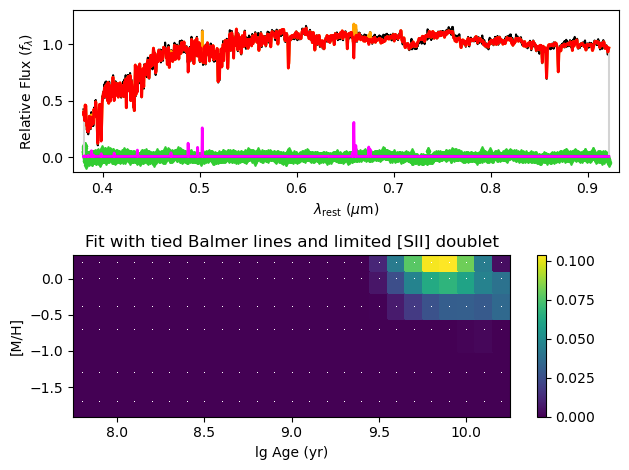

In [26]:
plt.clf()
plt.subplot(211)
pp.plot()

plt.subplot(212)
sps.plot(light_weights/light_weights.sum())  # Normalize to light fractions
txt1 = "tied" if tie_balmer else "free"
txt2 = "limited" if limit_doublets else "free"
plt.title(f"Fit with {txt1} Balmer lines and {txt2} [SII] doublet")
plt.tight_layout()
plt.pause(5);